# Introduction

175 000 000 000 000 GB - this amount of data will be produced by the world population by 2025 according to <a href=https://www.seagate.com/files/www-content/our-story/trends/files/idc-seagate-dataage-whitepaper.pdf>IDC research</a>. 
It's equivalent of 175 ZB (Zetta bytes). To give You a better view, currently we produce "only" about 40 ZB. Rapid increase of amount of data brings with it the rapid development of processing technology as well as new terms related to data like Big Data and data-driven decision making in business.

It is obvious, that data have greater and greater impact on the reality.

Services like Facebook, Youtube or Spotify generates bilions of users activity records daily. Most common application of this data is to discover and fulfill users needs, and make business more profitable. This may be achieved in three basic ways:
- acquiring new users into the platform
- upselling services to current users
- preventing churn

Each way requires specific toolkit and methods to deal with succesfully. Acquiring new users is connected with targeting the ads to the specified group, based on similar characteristics as the users. In this case, discovering various patterns in users data is invaluable. On the otherside, the upselling may require deeper research of users needs, extending the current services and development of new ones and, finally, encourage users to get them.

Last, but not least, discovering patterns in churn data may turn out into a predictive model that will detect users that may leave the platform to some reason. This could allow understand users problems and needs as well as better support them.

**This Notebook demonstrates how to predict churn using Big Data processing framework - Spark.** The data comes from fictive music streaming company named *Sparkify*.

# Problem definition

The project aims to predict whether the user cancelel the service or not based on past behaviour data.
In the Sparkify dataset, the churn is defined as a service cancellation confirmation made by user.  The main challenge related to churn is its **frequency**. Churn is a rare phenomena what leads to unbalanced data in terms of number of users who canceled a service or not.

## Hypotheses
Why do users leave the service? What are possible reasons? Well, it's actually quite simple. I would stop using the service if the content dont match me or there are tons of bugs. I would use the less and less and one day leave it at all. When there weren't any of my friends who used the service, I would take decision to left even sooner because there wouldn't be anything what kept me there.

Let's break this into the bullet points - this are the traces that may be related to churn:
1. Decrease in number of played songs during last period vs a period before or overall smaller number of played songs than average.
1. How much time does user spend on a platform?
1. Increased number of thumbs down.
1. A little number of added contacts.
1. Unusual number of looking for settings/help page.
1. Occurence of errors
1. From how long a user use a service? New users probably are more likely to cancel the service.

In [1]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.1)


In [78]:
from pyspark.sql import session
import pyspark.sql.functions as F
import warnings
warnings.filterwarnings("ignore")

# from pyspark.sql.functions import udf, min, max, count, countDistinct, concat, mean, stddev, sum, col, isnan, when, array_contains, element_at, desc, asc
# from pyspark.sql.functions import from_unixtime, to_date, month, regexp_replace, regexp_extract, round
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DecimalType, FloatType, ByteType, ShortType, BinaryType, BooleanType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, BinaryLogisticRegressionSummary, GBTClassifier
# from pyspark.ml.evaluation import BinaryLogisticRegressionSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 
import seaborn as sns

import pandas as pd
import numpy as np
from time import time

DATASET_MINI_PATH = 'mini_sparkify_event_data.json'

In [3]:
# create a Spark session
spark = session.SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

df = spark.read.json(DATASET_MINI_PATH)
DATASET_MINI_PATH = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

# Data understanding

The provided dataset is a subset of larger one, containing users activity logs of *Sparkify* music service.
Dataset consits of following fields:

```root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)```

Each row stands for a log of user's action. **In order to detect churn, the `page` field is a key as it contains `Cancellation Confirmation` option.** Basically, a user that have entered `Cancellation Confirmation`, have canceled the service at all.

### Glimpse of relevant categorical columns

In [5]:
for colname in ['auth', 'gender', 'level', 'method', 'page', 'status', 'userAgent']:
    df.groupby(colname).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526

As we can see there are over 8k of null userAgent as well as gender.

In [6]:
df.where(col("gender").isNull()).select('userId').dropDuplicates().show()

+------+
|userId|
+------+
|      |
+------+



And all of them have no `userId` assigned - probably they come from not logged users. Our area of interest is limited to activity of logged users so let's remove this activity.

In [7]:
df.where(col("gender").isNull()).select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [8]:
df = df.filter(df["userId"] != "")

In [9]:
df.where(col("gender").isNull()).select('userId').dropDuplicates().collect() # No records returned as expected

[]

As we can see most of the actions are related to logged users. Let's look at this again.

In [10]:
df.groupby(['auth', 'page']).count().show()

+---------+--------------------+------+
|     auth|                page| count|
+---------+--------------------+------+
|Logged In|              Logout|  3226|
|Logged In|           Thumbs Up| 12551|
|Logged In|         Roll Advert|  3933|
|Logged In|      Submit Upgrade|   159|
|Logged In|            Settings|  1514|
|Logged In|         Thumbs Down|  2546|
|Logged In|       Save Settings|   310|
|Logged In|                Help|  1454|
|Logged In|            NextSong|228108|
|Logged In|               About|   495|
|Logged In|     Add to Playlist|  6526|
|Logged In|               Error|   252|
|Logged In|                Home| 10082|
|Cancelled|Cancellation Conf...|    52|
|Logged In|          Add Friend|  4277|
|Logged In|           Downgrade|  2055|
|Logged In|             Upgrade|   499|
|Logged In|              Cancel|    52|
|Logged In|    Submit Downgrade|    63|
+---------+--------------------+------+



**Only 52 rows from our mini dataset are related to churn.** I will sign activity of users that picked `Cancellation Confirmation`. It's neccesarry in order to further data exploration.

In [11]:
flag_cancelled_auth_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Consider the full range of rows partitioned by 'userId'. We know that `Cancellation Confirmation` is the last event 
# for the all users, that have it.
windowval = Window.partitionBy("userId")
df = df.withColumn("cancelled", flag_cancelled_auth_event("page"))
df = df.withColumn("phase_cancelled", F.max("cancelled").over(windowval))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', downgraded=0, cancelled=0)

Since we have marked each user that confirmed the service cancellation, we can mark each activity of such users. Before we do this, let's check if there exist any user activity after the `Cancellation Confirmation`. Theoretically, there shouldn't, however data sometimes like to surprise.

In [13]:
df.createOrReplaceTempView('traffic')
spark.sql('''
WITH thresholds AS (
    SELECT userId, ts
    FROM traffic
    WHERE cancelled = 1
)

SELECT COUNT(*)
FROM traffic 
JOIN thresholds
    ON traffic.userId = thresholds.userId AND traffic.ts > thresholds.ts
''').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



Data is consistent - there is no activity after `Cancellation Confirmation` event.

# Exploratory Data Analysis

In [14]:
# Convert timestamp to date and make date calculations
df = df.withColumn('datetime', F.from_unixtime(col("ts") / 1000))
df = df.withColumn('date', F.to_date("datetime"))
df = df.withColumn('month', F.month("datetime"))

# Process registration date
df = df.withColumn('datetime_registered', F.from_unixtime(col("registration") / 1000))
df = df.withColumn('date_registered', F.to_date("datetime_registered"))
df = df.withColumn('month_registered', F.month("datetime_registered"))
df = df.withColumn('days_from_registration', F.datediff(col('datetime'), col('datetime_registered')))

# Calculate:
# - DAU - daily active users
# - DS - daily sessions 
# - PV / DAU - page views per user
# - PV / DS - page views per session (later it turned out that it's close to be the same to 'per user' calculations)
# Above metrics are broken down by churned/active users.
dates = df.select('date').distinct()
pages = df.select('page').distinct()
phase_cancelled = df.select('phase_cancelled').distinct()
daily = dates.crossJoin(pages).crossJoin(phase_cancelled)


daily_users_sessions = df.groupby('date', 'phase_cancelled')\
    .agg(F.countDistinct('userId').alias('DAU'), 
         F.countDistinct('sessionId').alias('DS')
        )  # daily active users and daily sessions

daily_events = df\
    .groupby('date', 'phase_cancelled', 'page')\
    .agg(F.count('userId').alias('pageCount'))

daily = daily.join(daily_events, on=['date', 'phase_cancelled', 'page'], how='left')
daily = daily.join(daily_users_sessions, on=['date', 'phase_cancelled'], how='left')
daily = daily.withColumn('pageCountPerUser', col('pageCount') / col('DAU'))
daily = daily.withColumn('pageCountPerSession', col('pageCount') / col('DS'))
daily = daily.fillna(0)

def days(i):
    return i*86400

# Calculate moving average of page views per user (and per session) - it's easier to observe trends.
ma7_window = Window.partitionBy('phase_cancelled', 'page').orderBy(col("date").cast('timestamp').cast('long')).rangeBetween(-days(7), 0)
daily = daily.withColumn('MA7pageCountPerUser', F.mean('pageCountPerUser').over(ma7_window))
daily = daily.withColumn('MA7pageCountPerSession', F.mean('pageCountPerSession').over(ma7_window))
pd_df = daily.toPandas()

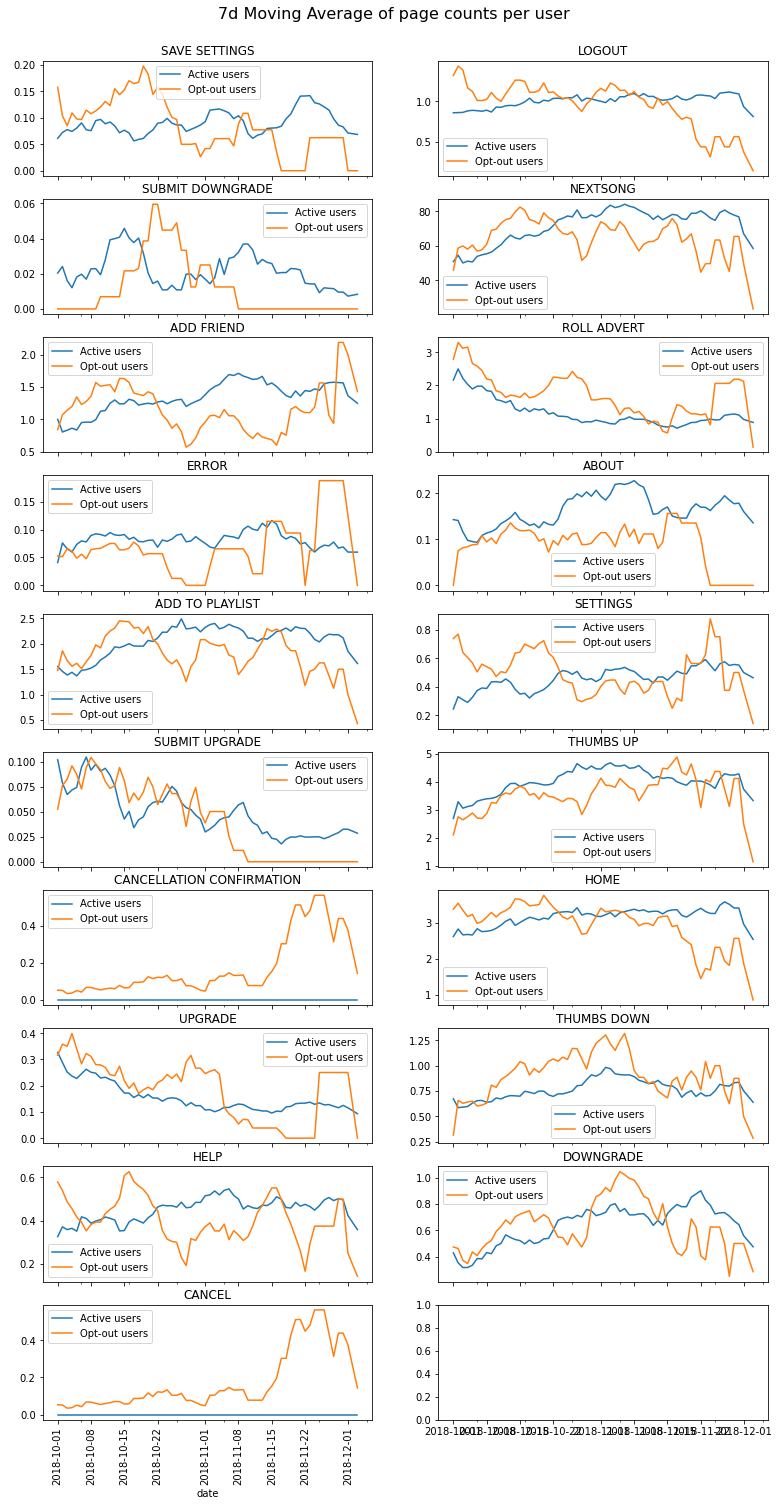

In [18]:
page_list = pd_df.page.unique().tolist()
month_day_fmt = mdates.DateFormatter('%m-%d') 
rows = round(len(page_list)/2)
cols = 2
ax_height = 2.5
ax_width = 6.5
fig_height = ax_height*rows
fig_width = ax_width*cols

fig, ax = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=True)
fig.suptitle('7d Moving Average of page counts per user', size=16, y=0.91)
for page_name, a in zip(page_list, ax.flatten()):
    if page_name:
        page_df = pd_df.query('page == @page_name')
        page_df.pivot(index='date', columns='phase_cancelled', values='MA7pageCountPerUser').plot(rot=90, title=page_name.replace('_', ' ').upper(), ax=a);
       
        #  pd_df.query('page == "Cancellation Confirmation" & pageCount >=1')[['date', 'pageCount']].plot(x='date', y='pageCount', style='.', ax=at)
        a.legend(['Active users','Opt-out users'])

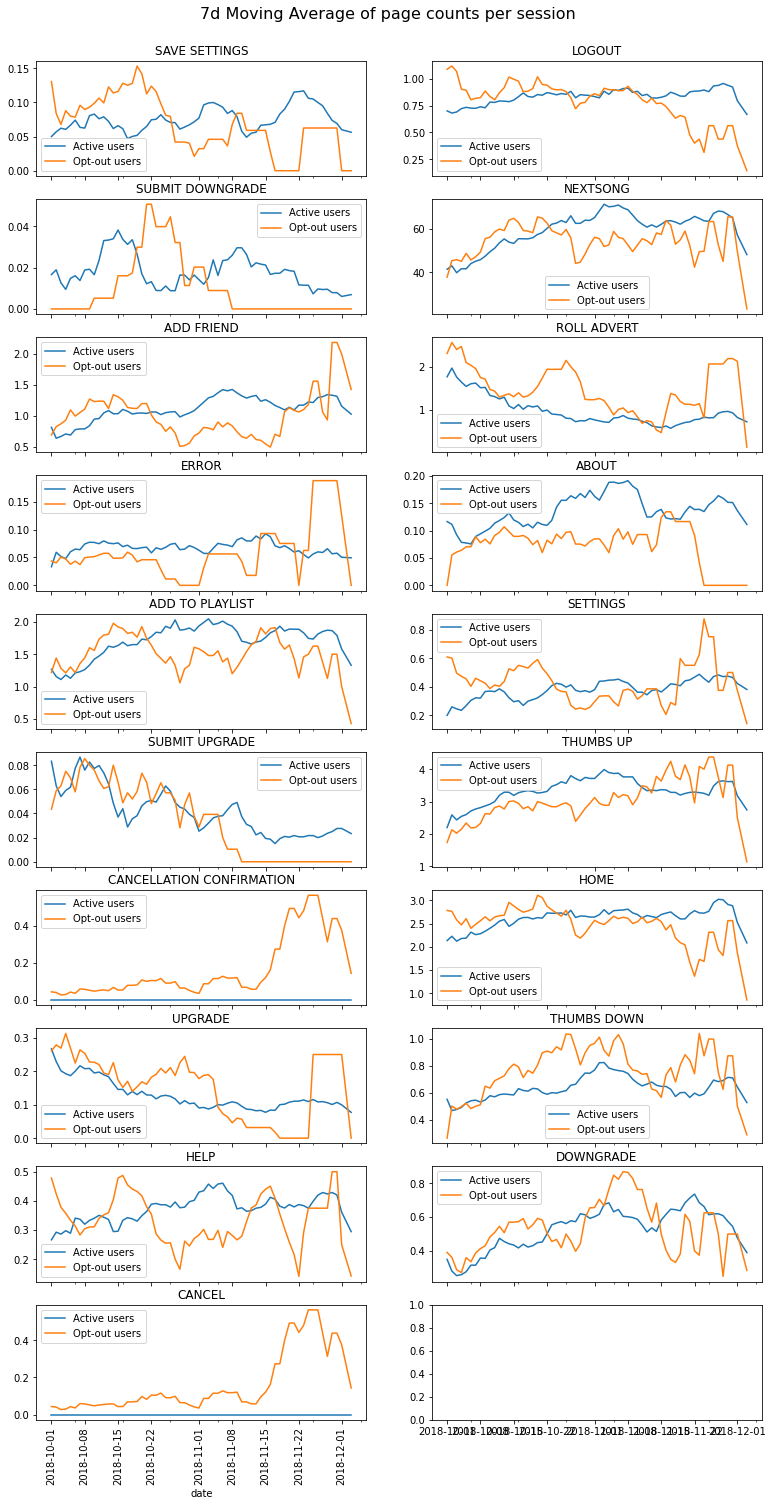

In [19]:
fig, ax = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=True)
fig.suptitle('7d Moving Average of page counts per session', size=16, y=0.91)
for page_name, a in zip(page_list, ax.flatten()):
    if page_name:
        page_df = pd_df.query('page == @page_name')
        page_df.pivot(index='date', columns='phase_cancelled', values='MA7pageCountPerSession').plot(rot=90, title=page_name.replace('_', ' ').upper(), ax=a);
        a.legend(['Active users','Opt-out users'])

By looking on moving average of various measures calculated per user (i.e. divided by Daily Active Users), we can clearly see a positive relation between churn and **thumbs down** and **roll advert**. In order to confirm the observations, let's check the Spearman correlation coefficient between churn and the measures:

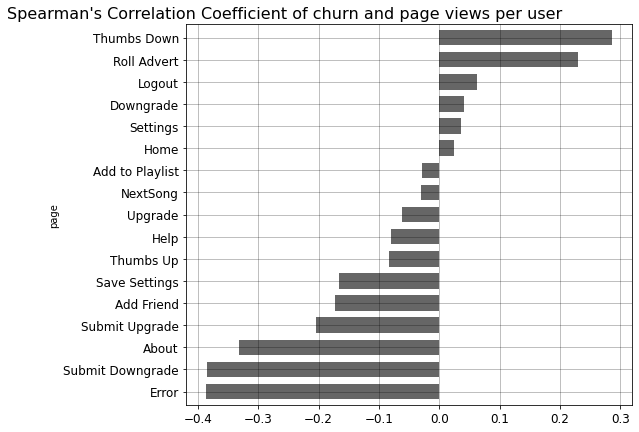

In [20]:
pd_df_filtered = pd_df.query('DAU != 0 & page != "Cancellation Confirmation" & page != "Cancel"')

corr_mpu = pd_df_filtered.pivot_table(index=['date', 'phase_cancelled'], columns='page', values='pageCountPerUser').reset_index('phase_cancelled').corr('spearman')['phase_cancelled'].drop('phase_cancelled')
corr_ma7_mpu = pd_df_filtered.pivot_table(index=['date', 'phase_cancelled'], columns='page', values='MA7pageCountPerUser').reset_index('phase_cancelled').corr('spearman')['phase_cancelled'].drop('phase_cancelled')

corr_mpu.dropna()\
         .sort_values().plot.barh(figsize=(8, 7), 
                                          fontsize=12, 
                                          alpha=0.6, 
                                          width=0.7, 
                                          color='black')

plt.title("Spearman's Correlation Coefficient of churn and page views per user", size=16, loc='left', x=-0.4)
plt.grid(lw=0.5, c='black', alpha=0.5)

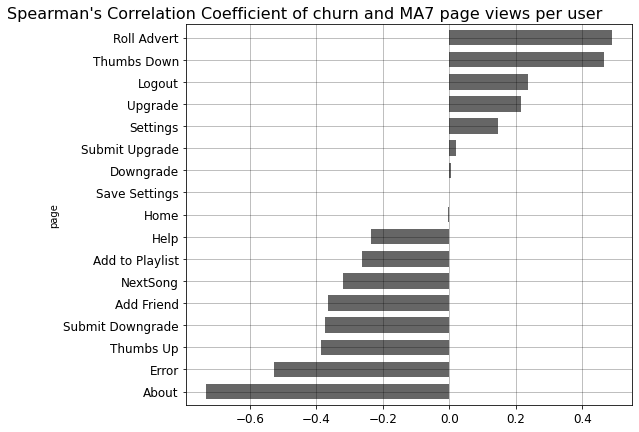

In [21]:
corr_ma7_mpu.dropna()\
         .sort_values().plot.barh(figsize=(8, 7), 
                                          fontsize=12, 
                                          alpha=0.6, 
                                          width=0.7, 
                                          color='black')

plt.title("Spearman's Correlation Coefficient of churn and MA7 page views per user", size=16, loc='left', x=-0.4)
plt.grid(lw=0.5, c='black', alpha=0.5)

In [22]:
corr_mpu = pd.DataFrame(corr_mpu).reset_index().sort_values(by='page').rename(columns={'page': 'feature', 'phase_cancelled':'corr'})
corr_ma7_mpu = pd.DataFrame(corr_ma7_mpu).reset_index().sort_values(by='page').drop('page', axis=1).rename(columns={'phase_cancelled': 'ma7_corr'})
corrs = pd.concat([corr_mpu, corr_ma7_mpu], axis=1).dropna(subset=['corr', 'ma7_corr'], how='all').set_index('feature').sort_values(by='ma7_corr', ascending=False)

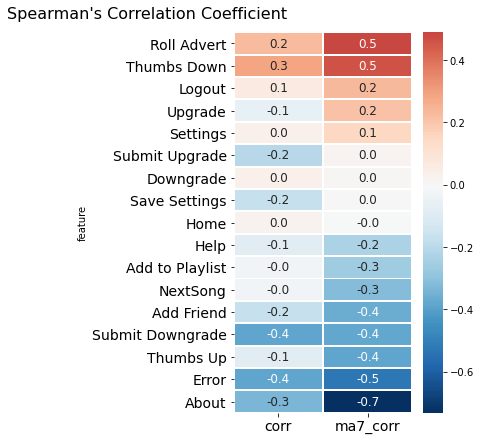

In [23]:
plt.figure(figsize=(4,7), dpi=72)
ax = sns.heatmap(corrs, annot=True, fmt='.1f', cmap='RdBu_r', center=0, lw=1, annot_kws={'fontsize':12}); #'RdBu_r', 
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title("Spearman's Correlation Coefficient", size=16, y=1.02, x=0.3, loc='right');

We observe multiple, quite high, positive Spearmann correlation coefficients for the calculated features (`corr`), additionally expressed by the moving average (`ma7_corr`). The highest positive correlation for **Roll Advert** amd **Thumbs Down**, weak correlation for **Logout** and **Upgrade**. 
We can see also the high negative correlation with **About** and **Error**. Negative correlation occured also for: **Thumbs Up**, **Submit Downgrade**, **Add Frient**, **Next Song**, **Add to Playlist** and **Help**. 

There still are some questions to be answered. What is the average session duration? What is the average sequence lenght?

In [24]:
sess = df.groupby('phase_cancelled', 'userId', 'sessionId')\
    .agg(F.max('itemInSession').alias('maxItemInSession'))\
    .groupby('phase_cancelled', 'userId')\
    .agg(F.mean('maxItemInSession').alias('avgItemsInSession'))

In [25]:
pd_sess = sess.toPandas()

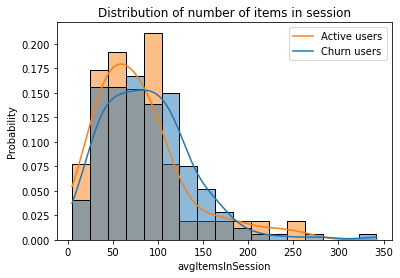

In [80]:
sns.histplot(data=pd_sess, 
             x='avgItemsInSession', 
             hue='phase_cancelled', 
             kde=True, 
             common_norm=False, 
             stat='probability')
plt.title('Distribution of number of items in session', size=16)
plt.legend(['Active users', 'Users who churned'])

**Active users have quite more items in a single session.**

In [27]:
pd_sess.corr('spearman')['phase_cancelled']['avgItemsInSession']

-0.10973247317466044

In [28]:
regs = df.select('date', 'phase_cancelled', 'userId','days_from_registration').distinct().toPandas()

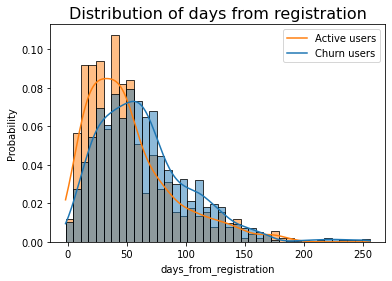

In [81]:
sns.histplot(data=regs, 
             x='days_from_registration', 
             hue='phase_cancelled', 
             kde=True, 
             common_norm=False, 
             stat='probability')

plt.title('Distribution of days from registration', size=16)
plt.legend(['Active users', 'Users who churned'])

**Opt-out users are more likely to have an account shorter time than active users.**

In [30]:
genders = df.select('phase_cancelled', 'userId','gender').distinct().toPandas()

In [31]:
genders_gr = genders.groupby(['phase_cancelled', 'gender']).count().reset_index().pivot(index='gender', columns='phase_cancelled', values='userId')
genders_gr = genders_gr.T

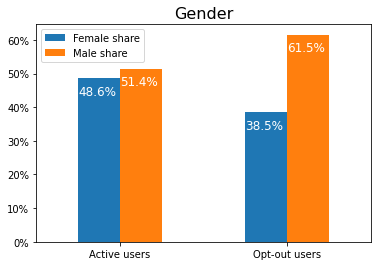

In [32]:
genders_gr['F share'] = genders_gr['F'] / (genders_gr['F'] + genders_gr['M'])
genders_gr['M share'] = genders_gr['M'] / (genders_gr['F'] + genders_gr['M'])
ax = genders_gr[['F share', 'M share']].plot.bar(rot=0)
ax.axes.set_xticklabels(['Active users', 'Users who churned'])
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.legend(['Female share', 'Male share'])
plt.title('Gender', size=16)
annot_params = {'va': 'top', 'ha': 'left', 'color': 'white', 'fontsize': 12}

for i in range(4):
    x = ax.get_children()[i].get_x()
    y = ax.get_children()[i].get_height()
    annot = f'{y*100:.1f}%'
    ax.annotate(annot, xy=(x, y-0.02), **annot_params);

**Males are more likely to cancel the service.**

# Create a training set

For how many users who churned there is a monthly data available?

In [34]:
df.filter('page == "Cancellation Confirmation"').groupby('date').agg(F.countDistinct('userId').alias('cancellations')).orderBy('date').collect()

[Row(date=datetime.date(2018, 10, 1), cancellations=1),
 Row(date=datetime.date(2018, 10, 2), cancellations=1),
 Row(date=datetime.date(2018, 10, 4), cancellations=1),
 Row(date=datetime.date(2018, 10, 5), cancellations=2),
 Row(date=datetime.date(2018, 10, 7), cancellations=2),
 Row(date=datetime.date(2018, 10, 8), cancellations=1),
 Row(date=datetime.date(2018, 10, 11), cancellations=1),
 Row(date=datetime.date(2018, 10, 12), cancellations=2),
 Row(date=datetime.date(2018, 10, 13), cancellations=1),
 Row(date=datetime.date(2018, 10, 14), cancellations=1),
 Row(date=datetime.date(2018, 10, 15), cancellations=2),
 Row(date=datetime.date(2018, 10, 16), cancellations=1),
 Row(date=datetime.date(2018, 10, 17), cancellations=3),
 Row(date=datetime.date(2018, 10, 19), cancellations=1),
 Row(date=datetime.date(2018, 10, 20), cancellations=3),
 Row(date=datetime.date(2018, 10, 22), cancellations=2),
 Row(date=datetime.date(2018, 10, 23), cancellations=1),
 Row(date=datetime.date(2018, 10, 24)

# Feature Engineering

In [36]:
spark.stop()
spark = session.SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

df = spark.read.json(DATASET_MINI_PATH)
df = df.filter(df["userId"] != "")
flag_downgrade_event = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, ByteType())
flag_cancelled_auth_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, ByteType())

df = df.withColumn("downgraded", flag_downgrade_event("page"))
df = df.withColumn("cancelled", flag_cancelled_auth_event("page"))

# Consider the full range of rows partitioned by 'userId'. We know that `Cancellation Confirmation` is the last event 
# for the all users, that have it. 
windowval = Window.partitionBy("userId")
df = df.withColumn("phase_cancelled", F.max("cancelled").over(windowval).cast(ByteType()))
df = df.filter(df.page != "Cancellation Confirmation")
df = df.filter(df.page != "Cancel")
df = df.filter(df.page != "Home")
df = df.withColumn('datetime', F.from_unixtime(col("ts") / 1000))
# df = df.withColumn('date', F.to_date("datetime"))
# df = df.withColumn('month', F.month("datetime"))
df = df.withColumn('datetimeReg', F.from_unixtime(col("registration") / 1000))
# df = df.withColumn('dateReg', F.to_date("datetimeReg"))
# df = df.withColumn('monthReg', F.month("datetimeReg"))
df = df.withColumn('daysFromReg', F.datediff(col('datetime'), col('datetimeReg')).cast(ShortType()))
activityWindow = Window.partitionBy("userId")

df = df.withColumn('lastActivity', F.max('datetime').over(windowval))
df = df.withColumn('daysFromLastActivity', F.datediff(col('lastActivity'), col('datetime')).cast(ShortType()))
df = df.filter(df.daysFromLastActivity < 60)
avgItemsInSession = df.groupby('userId', 'sessionId')\
                        .agg(F.max('itemInSession').alias('maxItemInSession'))\
                        .groupby('userId')\
                        .agg(F.mean('maxItemInSession').cast(ShortType()).alias('avgItemsInSession'))

# IntegerType, DecimalType, FloatType, ByteType, ShortType, BinaryType, BooleanType
def days(i):
    return i*86400

users_sessions = df.groupby('userId', 'gender', 'phase_cancelled').agg(F.countDistinct('sessionId').alias('sessCount'),
                                                            F.max('daysFromReg').cast(ShortType()).alias('daysFromReg'))

users_events = df.groupby('userId', 'page').agg(F.count('sessionId').alias('pageCount'))
users_sessions = users_sessions.join(users_events, on='userId', how='left')\
                               .join(avgItemsInSession, on='userId', how='left')

users_sessions = users_sessions.withColumn('pageCountPerSess', (col('pageCount') / col('sessCount')).cast(DecimalType(6, 2)))
final_df = users_sessions.select('phase_cancelled', 'userId', 'gender', 'avgItemsInSession', 'daysFromReg', 'page', 'pageCountPerSess')\
    .groupby('phase_cancelled', 'userId', 'gender', 'avgItemsInSession', 'daysFromReg').pivot('page').avg('pageCountPerSess')
final_df = final_df.fillna(0)

In [37]:
assembler = VectorAssembler(inputCols=['avgItemsInSession', 'daysFromReg', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade',
                                      'Error', 'Help', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings',
                                      'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade'],
                           outputCol='Feats')
final_df = assembler.transform(final_df)
# LogisticRegression, RandomForestClassifier, BinaryLogisticRegressionSummary, GBTClassifier

dataset = final_df.select(col("phase_cancelled").alias("label"), col("Feats").alias("features"))
train, test = dataset.randomSplit([0.8, 0.2], seed=2020)

In [38]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   43|
|    0|  138|
+-----+-----+



In [39]:
# Calculate weights

In [40]:
label_0_cnt = train.filter(train.label == 1).count()
label_1_cnt = train.count() - label_0_cnt
label_0_weight = 1.0
label_1_weight = label_1_cnt / label_0_cnt

In [41]:
assign_weight = F.udf(lambda x: label_1_weight if x == 1 else label_0_weight, FloatType())

In [42]:
train = train.withColumn('weightCol', assign_weight(col('label')))
train.take(1)

[Row(label=0, features=DenseVector([54.0, 55.0, 0.14, 0.57, 1.0, 0.0, 0.0, 0.29, 0.71, 39.29, 7.43, 0.0, 0.0, 0.0, 0.0, 0.71, 2.43, 0.29]), weightCol=1.0)]

# Modelling

In [43]:
lr = LogisticRegression(maxIter=5, regParam=0.0, weightCol='weightCol')

In [44]:
m = lr.fit(train)

In [45]:
test_results = m.transform(test)
train_results = m.transform(train)

In [46]:
def classification_report(test_results, train_results, label):
    
    out_reports = dict()
    for name, results in {'train': train_results, 'test': test_results}.items():
        TOTAL = results.count()
        N = results.filter(results.label == 0).count()
        P = results.filter(results.label == 1).count()
        TN = results.filter((results.label == results.prediction) & (results.label == 0)).count() # 34
        TP = results.filter((results.label == results.prediction) & (results.label == 1)).count() # 3
        FN = P - TP
        FP = N - TN
        PR = TP / (TP + FP)
        RC = TP / P
        ACC = (TP+TN) / TOTAL
        F1 = 2 * (PR * RC) / (PR + RC)

        print(f"""------ {name.upper()} SET EVALUATION REPORT ------
        Total labels:\t{TOTAL}
        FP:  \t{FP}
        FN:  \t{FN}
        TP:  \t{TP}\tout of {P} positive
        TN:  \t{TN}\tout of {N} negative
        Prec:\t{PR:.3f}
        Rec: \t{RC:.3f}
        Acc: \t{ACC:.3f}
        F1:  \t{F1:.3f}
        ----------------------------------""")

        report = dict(
            TOTAL = TOTAL,
            P = P,
            N = N,
            TN = TN,
            TP = TP,
            FN = FN,
            FP = FP,
            PR = PR,
            RC = RC,
            ACC = ACC,
            F1 = F1,
        )
        out_reports[name] = report
    
    out_reports['label'] = label    
    return out_reports

In [47]:
res1 = classification_report(test_results, train_results, 'LogRegWeighted') # 0.508, 0.721, 0.768, 0.596

------ TRAIN SET EVALUATION REPORT ------
        Total labels:	181
        FP:  	30
        FN:  	12
        TP:  	31	out of 43 positive
        TN:  	108	out of 138 negative
        Prec:	0.508
        Rec: 	0.721
        Acc: 	0.768
        F1:  	0.596
        ----------------------------------
------ TEST SET EVALUATION REPORT ------
        Total labels:	44
        FP:  	8
        FN:  	3
        TP:  	6	out of 9 positive
        TN:  	27	out of 35 negative
        Prec:	0.429
        Rec: 	0.667
        Acc: 	0.750
        F1:  	0.522
        ----------------------------------


In [48]:
m.coefficients

DenseVector([-0.0003, -0.0164, -5.6059, -0.2231, 0.0222, 0.5505, -2.8553, 0.2353, 0.0086, -0.001, 0.1896, 0.1252, 0.6316, 0.1527, 6.0909, 1.0604, -0.043, 0.3458])

As we can see on our logistic model coefficients, there are some features that are quite irrelevant, having weights close to 0. 
Since, I'm going to apply tree-based model as well, I'll keep those features for now.

In [49]:
m.interceptVector

DenseVector([0.137])

In [83]:
rf = RandomForestClassifier(numTrees=10, maxDepth=10, seed=2021)
rf_model = rf.fit(train)
test_results_rf = rf_model.transform(test)
train_results_rf = rf_model.transform(train)
res_rf = classification_report(test_results_rf, train_results_rf, 'RF')

------ TRAIN SET EVALUATION REPORT ------
        Total labels:	181
        FP:  	0
        FN:  	1
        TP:  	42	out of 43 positive
        TN:  	138	out of 138 negative
        Prec:	1.000
        Rec: 	0.977
        Acc: 	0.994
        F1:  	0.988
        ----------------------------------
------ TEST SET EVALUATION REPORT ------
        Total labels:	44
        FP:  	1
        FN:  	5
        TP:  	4	out of 9 positive
        TN:  	34	out of 35 negative
        Prec:	0.800
        Rec: 	0.444
        Acc: 	0.864
        F1:  	0.571
        ----------------------------------


In [51]:
gbt = GBTClassifier(featuresCol='features', 
                    labelCol='label', 
                    predictionCol='prediction', 
                    maxDepth=7, 
                    maxBins=32, 
                    minInstancesPerNode=1, 
                    minInfoGain=0.0, 
                    maxMemoryInMB=256, 
                    cacheNodeIds=False, 
                    checkpointInterval=10, 
                    lossType='logistic', 
                    maxIter=50, 
                    stepSize=0.1, 
                    seed=2021, 
                    subsamplingRate=0.9, 
                    featureSubsetStrategy='all')
gbt_model = gbt.fit(train)
test_results_gbt = gbt_model.transform(test)
train_results_gbt = gbt_model.transform(train)

res_gbt = classification_report(test_results_gbt, train_results_gbt, 'GBT')

------ TRAIN SET EVALUATION REPORT ------
        Total labels:	181
        FP:  	0
        FN:  	0
        TP:  	43	out of 43 positive
        TN:  	138	out of 138 negative
        Prec:	1.000
        Rec: 	1.000
        Acc: 	1.000
        F1:  	1.000
        ----------------------------------
------ TEST SET EVALUATION REPORT ------
        Total labels:	44
        FP:  	2
        FN:  	5
        TP:  	4	out of 9 positive
        TN:  	33	out of 35 negative
        Prec:	0.667
        Rec: 	0.444
        Acc: 	0.841
        F1:  	0.533
        ----------------------------------


In [76]:
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20]).build()
#     .addGrid(gbt.stepSize, [0.1, 0.05])\
#     .addGrid(gbt.maxIter, [10, 30])\
    

In [77]:
rf = RandomForestClassifier(maxDepth=10, seed=2021)

cv = CrossValidator(estimator=rf,
                   estimatorParamMaps=paramGrid,
                   evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                   numFolds=3)

In [79]:
s = time()
cv_model = cv.fit(train)
test_results_cv = cv_model.transform(test)
train_results_cv = cv_model.transform(train)
res_gbt = classification_report(test_results_cv, train_results_cv, 'CV-GBT')
e = time()
delta = (e - s)/60
print(f'Total time: {delta:.2f} min')

------ TRAIN SET EVALUATION REPORT ------
        Total labels:	181
        FP:  	0
        FN:  	1
        TP:  	42	out of 43 positive
        TN:  	138	out of 138 negative
        Prec:	1.000
        Rec: 	0.977
        Acc: 	0.994
        F1:  	0.988
        ----------------------------------
------ TEST SET EVALUATION REPORT ------
        Total labels:	44
        FP:  	3
        FN:  	4
        TP:  	5	out of 9 positive
        TN:  	32	out of 35 negative
        Prec:	0.625
        Rec: 	0.556
        Acc: 	0.841
        F1:  	0.588
        ----------------------------------
Total time:11.97 min


In [82]:
cv_model.avgMetrics

[0.7118560410201277, 0.7118560410201277]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.